**Метод главных компонент**

№1. Подключим все необходимые библиотеки

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score

№2. Скачиваем базу данных MNIST при помощи функции load_mnist из пакета 
mnist.p. Получаем массивы картинок в виде массива Х и ответов Lables.y

In [3]:
from mnist import load_mnist
train, validation, test = load_mnist()

X_train, y_train = train
X_validation, y_validation = validation
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


№3. При помощи функции matplotlib.pyplot.imshow рисуем несколько картинок из Х.

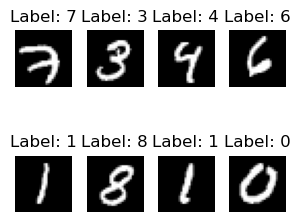

In [42]:
import matplotlib.pyplot as plt

images = 8    # Количество изображений для отображения

fig, axes = plt.subplots(2, 4, figsize=(3, 3))    # Создаем фигуру с подграфиками
axes = axes.flatten()      # Плоский массив осей для удобства перебора

for i in range(images):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f'Label: {y_train[i]}')
    axes[i].axis('off')  # Убираем оси

plt.tight_layout()
plt.show()

**Алгоритм PCA**

№4. Реализуем шаги 1-3 внутри метода fit(), и шаг 4 внутри метода 
transform() класса my_PCA.координатах

In [20]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None
        self.mean = None

    def fit(self, X):
        # Шаг 1: Центрирование данных
        self.mean = np.mean(X, axis=0)
        Xc = X - self.mean
        
        # Шаг 2: Вычисление матрицы ковариации (можно пропустить)
        # C = np.cov(Xc, rowvar=False) 
        
        # Шаг 3: Вычисление собственных векторов и значений
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        self.eigenvalues = S**2 / (X.shape[0] - 1)  # Собственные значения
        self.eigenvectors = Vt.T  # Собственные векторы

        if self.n_components is not None:
            self.eigenvalues = self.eigenvalues[:self.n_components]
            self.eigenvectors = self.eigenvectors[:, :self.n_components]

    def transform(self, X):
        Xc = X - self.mean
        return np.dot(Xc, self.eigenvectors)

№5. Заметим, что собственные значения уже упорядочены в порядке убывания. Построим график собственных значений, а также график отношения кумулятивной суммы к их полной сумме. 

Какую долю дисперсии данных покрывают первые 15 главных компонент? 

Как связаны между собой собственные числа и дисперсия данных?

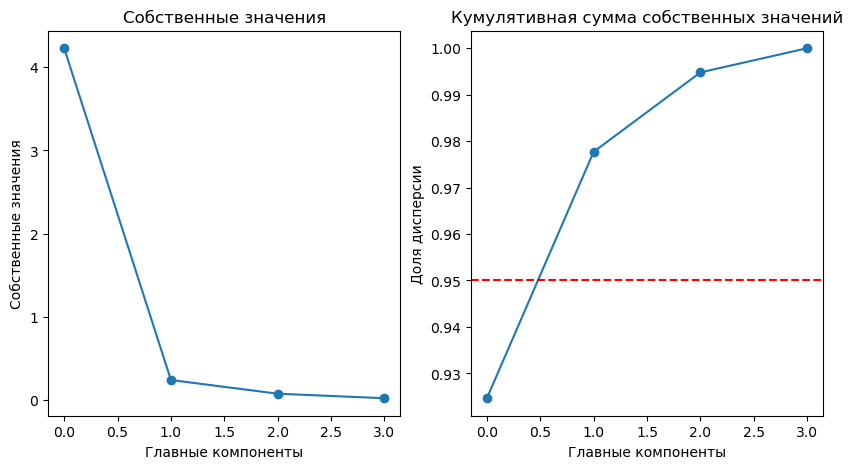

Доля дисперсии первых 15 главных компонент: 1.0


In [44]:
from sklearn.datasets import load_iris

# Загружаем данные
data = load_iris()
X = data.data
y = data.target

# Применяем PCA
pca = my_PCA()
pca.fit(X)

# График собственных значений
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.eigenvalues, marker='o')
plt.title('Собственные значения')
plt.xlabel('Главные компоненты')
plt.ylabel('Собственные значения')

# График кумулятивной суммы
cumulative_variance = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.subplot(1, 2, 2)
plt.plot(cumulative_variance, marker='o')
plt.title('Кумулятивная сумма собственных значений')
plt.xlabel('Главные компоненты')
plt.ylabel('Доля дисперсии')
plt.axhline(y=0.95, color='r', linestyle='--')  # Линия для 95%
plt.show()

# Доля дисперсии первых 15 главных компонент
variance_covered = cumulative_variance[:15]
print("Доля дисперсии первых 15 главных компонент:", variance_covered[-1])


№6. Изобразим на графике точки датасета в первых двух координатах главных компонент.

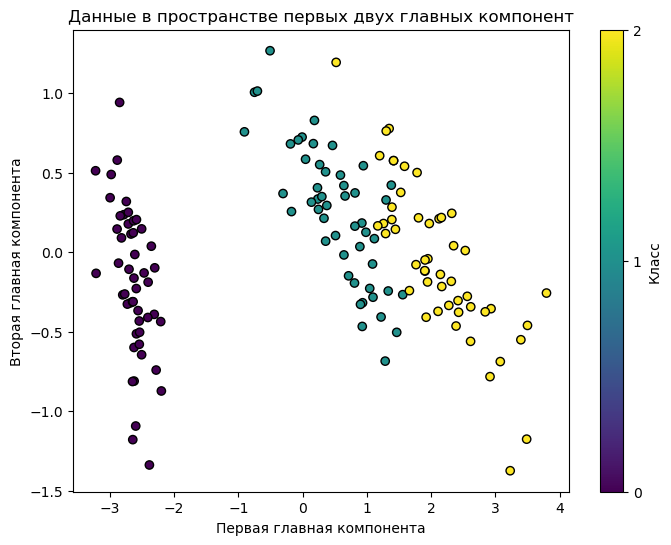

In [45]:
# Преобразуем данные в координаты главных компонент
X_pca = pca.transform(X)

# График точек в первых двух координатах главных компонент
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('Данные в пространстве первых двух главных компонент')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(scatter, ticks=[0, 1, 2], label='Класс')
plt.show()

**Выводы**: Собственные значения показывают важность каждой главной компоненты. Чем больше собственное значение, тем больше дисперсии оно объясняет. На графике с точками в пространстве главных компонент можно оценить, насколько хорошо классы разделены. Если точки разных классов располагаются в разных областях графика, это указывает на хорошую линейную разделимость.

**Алгоритм kNN**

№7. Реализуем метод k-ближайших соседей в виде класса my_kNN. 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits

class my_kNN:   
    def __init__(self, n_neighbors=5):    #инициализация количества соседей
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        prediction = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)    #расстояния до всех обучающих объектов
            k_ind = np.argsort(distances)[:self.n_neighbors]         #индексы k ближайших соседей
            k_lab = self.y_train[k_ind]
            pred_lab = np.argmax(np.bincount(k_lab))               #предсказание класса по наиболее частой метке (метки строчкой выше 'k_lab')
            prediction.append(pred_lab)
        return np.array(prediction)

№8. Разбиваем данные X и labels на обучающую и тестовую выборку, используя функцию train_test_split из модуля sklearn.model_selection.

In [29]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

№9. Создаем классификатор my_kNN с числом соседей равным 5. Обучаем классификатор на обучающих данных. Вычисляем точность на тестовой выборке, используя функцию accuracy_score из модуля sklearn.metrics. 

Какова точность полученного алгоритма?

In [31]:
knn = my_kNN()   #создаем классификатор

knn.fit(X_train, y_train)  #обучаем 
y_pred = knn.predict(X_test) #предсказываем
accuracy = accuracy_score(y_test, y_pred) #считаем точность с помощью встроенной функции

print("Точность алгоритма:", "%.2f" % accuracy)

Точность алгоритма: 0.99


№10. Уменьшаем размерность данных с помощью реализованного выше метода главных компонент. Применяем алгоритм k-ближайших соседей к преобразованным данным, пробуя разные значения k и количество компонент. Найдем параметры, при которых алгоритм даёт наибольшую точность на тестовой выборке.

In [32]:
baccuracy = 0
bneighbors = 0
bcomponents = 0

for n_components in range(1, X_train.shape[1] + 1):         #перебираем компоненты (кол-во)
    pca = my_PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    for n_neighbors in range(1, 31):                         #перебираем соседей (кол-во)
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)            #считаем точность для каждой комбинации параметров
        if accuracy > best_accuracy:                         #выбираем лучшую
            baccuracy = accuracy
            bneighbors = n_neighbors
            bcomponents = n_components

print("Максимальная точность алгоритма:", "%.2f" % best_accuracy)
print("Оптимальное количество соседей:", best_n_neighbors)
print("Оптимальное количество компонент:", best_n_components)

Максимальная точность алгоритма: 0.99
Оптимальное количество соседей: 8
Оптимальное количество компонент: 15


**Выводы по всей работе**

kNN используется для классификации и регрессии, в то время как PCA — для уменьшения размерности и предварительной обработки данных. 

 kNN зависит от расстояний между объектами, в то время как PCA фокусируется на дисперсии и корреляциях между признаками

Оба метода могут использоваться совместно: например, PCA может предварительно применяться для уменьшения размерности перед использованием kNN для классификации.и.